In [1]:
import os
import csv
root = '/Users/biraj/Downloads/ImageAnnotations/test/'
image_paths = []

# Specify the allowed image extensions
allowed_extensions = {'.png', '.jpg', '.jpeg'}

# Walk through the directory and add only image files with the allowed extensions
for path, subdirs, files in os.walk(root):
    for name in files:
        # Check the file extension and add it to the list if it's an image
        if any(name.lower().endswith(ext) for ext in allowed_extensions):
            image_paths.append(os.path.join(path, name))

print(image_paths)  # To verify the image paths

[]


In [2]:
print(len(image_paths))

0


In [6]:
# !pip install open-flamingo

In [7]:
from open_flamingo import create_model_and_transforms

model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path="togethercomputer/RedPajama-INCITE-Base-3B-v1",
    tokenizer_path="togethercomputer/RedPajama-INCITE-Base-3B-v1",
    cross_attn_every_n_layers=2
)

# grab model checkpoint from huggingface hub
from huggingface_hub import hf_hub_download
import torch

checkpoint_path = hf_hub_download("openflamingo/OpenFlamingo-4B-vitl-rpj3b", "checkpoint.pt")
model.load_state_dict(torch.load(checkpoint_path), strict=False)


open_clip_model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/Users/biraj/yes/envs/env-ait-ml/lib/python3.8/site-packages/open_clip/factory.py:372: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.69G [00:00<?, ?B/s]

/Users/biraj/yes/envs/env-ait-ml/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Flamingo model initialized with 1089480736 trainable parameters


checkpoint.pt:   0%|          | 0.00/5.01G [00:00<?, ?B/s]

_IncompatibleKeys(missing_keys=['vision_encoder.class_embedding', 'vision_encoder.positional_embedding', 'vision_encoder.proj', 'vision_encoder.conv1.weight', 'vision_encoder.ln_pre.weight', 'vision_encoder.ln_pre.bias', 'vision_encoder.transformer.resblocks.0.ln_1.weight', 'vision_encoder.transformer.resblocks.0.ln_1.bias', 'vision_encoder.transformer.resblocks.0.attn.in_proj_weight', 'vision_encoder.transformer.resblocks.0.attn.in_proj_bias', 'vision_encoder.transformer.resblocks.0.attn.out_proj.weight', 'vision_encoder.transformer.resblocks.0.attn.out_proj.bias', 'vision_encoder.transformer.resblocks.0.ln_2.weight', 'vision_encoder.transformer.resblocks.0.ln_2.bias', 'vision_encoder.transformer.resblocks.0.mlp.c_fc.weight', 'vision_encoder.transformer.resblocks.0.mlp.c_fc.bias', 'vision_encoder.transformer.resblocks.0.mlp.c_proj.weight', 'vision_encoder.transformer.resblocks.0.mlp.c_proj.bias', 'vision_encoder.transformer.resblocks.1.ln_1.weight', 'vision_encoder.transformer.resbloc

In [9]:
from PIL import Image
import requests

"""
Step 1: Load images
"""
demo_image_one = Image.open('./sample_image/cat9_img1.jpeg')

"""
Step 2: Preprocessing images
Details: For OpenFlamingo, we expect the image to be a torch tensor of shape 
 batch_size x num_media x num_frames x channels x height x width. 
 In this case batch_size = 1, num_media = 3, num_frames = 1,
 channels = 3, height = 224, width = 224.
"""
vision_x = [image_processor(demo_image_one).unsqueeze(0)]
vision_x = torch.cat(vision_x, dim=0)
vision_x = vision_x.unsqueeze(1).unsqueeze(0)

"""
Step 3: Preprocessing text
Details: In the text we expect an <image> special token to indicate where an image is.
 We also expect an <|endofchunk|> special token to indicate the end of the text 
 portion associated with an image.
"""
tokenizer.padding_side = "left" # For generation padding tokens should be on the left
lang_x = tokenizer(
    ["<image>An image of two cats.<|endofchunk|><image>An image of a bathroom sink.<|endofchunk|><image>An image of"],
    return_tensors="pt",
)


"""
Step 4: Generate text
"""
generated_text = model.generate(
    vision_x=vision_x,
    lang_x=lang_x["input_ids"],
    attention_mask=lang_x["attention_mask"],
    max_new_tokens=20,
    num_beams=3,
)

print("Generated text: ", tokenizer.decode(generated_text[0]))


Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image>An image of two cats.<|endofchunk|><image>An image of a bathroom sink.<|endofchunk|><image>An image of a basketball hoop.An image of a basketball court.An image of a basketball player.An


# BLIP For 600 Custom Images

In [37]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration


In [38]:

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

results = []



def predict_step(image_paths, output_csv_path):
    result = []
    for image_path in image_paths:
        raw_image = Image.open(image_path).convert('RGB')

        # conditional image captioning
        text = "a photography of"
        inputs = processor(raw_image, text, return_tensors="pt")

        out = model.generate(**inputs)
        conditional_image_caption = processor.decode(out[0], skip_special_tokens=True)
        # print(processor.decode(out[0], skip_special_tokens=True))

        # unconditional image captioning
        inputs = processor(raw_image, return_tensors="pt")
        out = model.generate(**inputs)
        unconditional_image_caption = processor.decode(out[0], skip_special_tokens=True)
        # print(processor.decode(out[0], skip_special_tokens=True))

        results.append({"image_name": image_path.split('/')[-1].split('.'), "conditional_image_captioning": conditional_image_caption,
                    "unconditional_image_captioning": unconditional_image_caption})
    

        with open(output_csv_path, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=["image_name", "conditional_image_captioning","unconditional_image_captioning"])
            writer.writeheader()  
            writer.writerows(results) 




In [39]:
output_csv_path = "/Users/biraj/Desktop/Github/image-caption-analysis/blip.csv"  # Output CSV file path
predict_step(image_paths,output_csv_path)

# Example Run

/Users/biraj/yes/envs/env-ait-ml/lib/python3.8/site-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a photography of a basketball player jumping to the basket
a man jumping in the air with a basketball


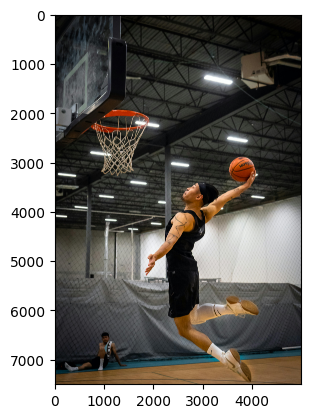

In [40]:
import matplotlib.pyplot as plt

raw_image = Image.open('./sample_image/cat9_img1.jpeg')
# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt")

out = model.generate(**inputs)
# conditional_image_caption = processor.decode(out[0], skip_special_tokens=True)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt")
out = model.generate(**inputs)
# unconditional_image_caption = processor.decode(out[0], skip_special_tokens=True)
print(processor.decode(out[0], skip_special_tokens=True))
plt.imshow(raw_image)